In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os 
sys.path.append(os.path.abspath('../'))
import torch
from time import time
from tqdm import tqdm
import drjit as dr
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F


from convolutions import *
from utils_fns import *
from utils_general import update_sigma_linear, run_scheduler_step, plt_errors, show_with_error
from optimizations import *
from utils_optim import run_optimization, run_grad_optimization, run_cg_optimization, run_bfgs_optimization
from utils_general import run_scheduler_step
from utils_mitsuba import get_mts_rendering, render_smooth
from read_scenes import create_scene_from_xml

if torch.cuda.is_available():
    device = 'cuda'
    print("is available")
    mi.set_variant('cuda_ad_rgb')

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!
is available


# Setup rendering

In [3]:
def apply_rotation(rotation, p, mat_id, init_vpos, factor=20):
    if isinstance(rotation, torch.Tensor):
        if rotation.dim() < 1:
            rotation = rotation.unsqueeze(0)
        rotation = rotation.tolist()[0]
    rot = mi.Transform4f.rotate([0, 1, 0], rotation * factor)
    p[mat_id] = dr.ravel(rot @ init_vpos)
    p.update()

def apply_color(color, p, mat_id, **kwargs):
    if isinstance(color, torch.Tensor):
        color = color.squeeze().tolist()
    p[mat_id] = mi.Color3f(color[0], color[1], color[2])
    p.update()

def setup_coffecup_scene(hparams):
    xmlpath = '../scenes/coffee_mug/classic-mug-backdrop-camMoreFrontal.xml'
    scene = create_scene_from_xml(xmlpath, resx=hparams['resx'], resy=hparams['resy'], integrator=hparams['integrator'],
                                  maxdepth=hparams['max_depth'], reparam_max_depth=hparams['reparam_max_depth'])
    params = mi.traverse(scene)
    mat_pos_id = 'PLYMesh_1.vertex_positions' # rotation
    mat_color_id = 'mat-Mug.brdf_0.reflectance.value' # color
    initial_vertex_positions = dr.unravel(mi.Point3f, params[mat_pos_id])
    mat_id = mat_color_id
    return scene, params, mat_id, initial_vertex_positions

def image_for_plotting(img):
    '''
    plot given torch tensor as img
    '''
    if img.shape[0] == 3:
        img = img.permute(1, 2, 0)
    img = img**.4545
    img_normalized = (img - img.min()) / (img.max() - img.min())
    return img_normalized.cpu().float().numpy()

Color is tensor([[0.9490, 0.6481, 0.6043]], device='cuda:0')


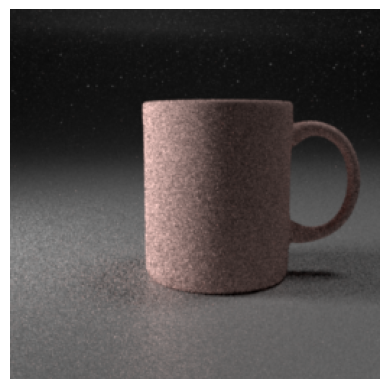

In [4]:
hparams = {'resx': 256,
            'resy': 256,
            'nsamples': 1,
            'sigma': 0.1,
            'render_spp': 32,
            'initial_translation': [9],
            'gt_translation': [0],
            'integrator': 'path',
            'max_depth': 6,
            'reparam_max_depth': 2}

scene, params, mat_id, initial_vertex_positions = setup_coffecup_scene(hparams) # rotation

ctx_args = {'scene': scene, 'params': params, 'spp': hparams['render_spp'],                     # rendering
            'init_vpos': initial_vertex_positions, 'mat_id': mat_id, #'update_fn': update_fn,    # rendering
            'sampler': 'importance', 'antithetic': True, 'nsamples': hparams['nsamples'],       # ours
            'sigma': hparams['sigma'], 'device': device}  

# gt_rot = torch.rand((1,)).to(device) * 9
# gt_color = torch.rand((3,)).to(device)

# generate input image
# reference_image = get_mts_rendering(gt_rot, update_fn, ctx_args)
# reference_image = get_mts_rendering(gt_color, apply_color, ctx_args)

def gen_data(device='cuda'):
    '''
    generate gt data and reference image
    '''
    gt_color = torch.rand((1,3)).to(device)
    reference_image = get_mts_rendering(gt_color, apply_color, ctx_args)
    reference_image = reference_image.permute(2, 0, 1)
    return gt_color, reference_image

gt_color, reference_image = gen_data()
print(f'Color is {gt_color}')
reference_image = image_for_plotting(reference_image)
plt.imshow(reference_image)
plt.axis('off')
plt.show()
    

# CNN

In [5]:
class CNN(nn.Module):
    def __init__(self, n_params):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
        self.fc1 = nn.Linear(16 * 8 * 8, 256)  # Assuming input image size is 256x256
        self.fc2 = nn.Linear(256, n_params)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = x.view(-1, 16*8*8)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train with encoder only

In [108]:
n_params = 3  # Number of output parameters
model = CNN(n_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {pytorch_total_params}')
criterion = nn.MSELoss()
model.to(device)

# optimization - encoder only
max_step = 5000
for i in range(max_step):
    gt_color, input_image = gen_data()
    output_color = model(input_image)

    loss = criterion(output_color, gt_color)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Loss at step {i}: {loss.item()}')
    if loss.item() < 1e-5:
        print(f'Converged at step {i}')
        break


Loss at step 0: 0.5385159850120544


Loss at step 100: 0.014370566233992577
Loss at step 200: 0.04652009159326553
Loss at step 300: 0.011683172546327114
Loss at step 400: 0.045715972781181335
Loss at step 500: 0.01822977140545845
Loss at step 600: 0.05286533758044243
Loss at step 700: 0.011779457330703735
Loss at step 800: 0.0002686652005650103
Loss at step 900: 0.0033071469515562057
Loss at step 1000: 0.003967151045799255
Converged at step 1045


Final loss: 8.81155938259326e-06
GT color: tensor([[0.6566, 0.7066, 0.1379]], device='cuda:0')
Output color: tensor([[0.7033, 0.6846, 0.1495]], device='cuda:0', grad_fn=<AddmmBackward0>)


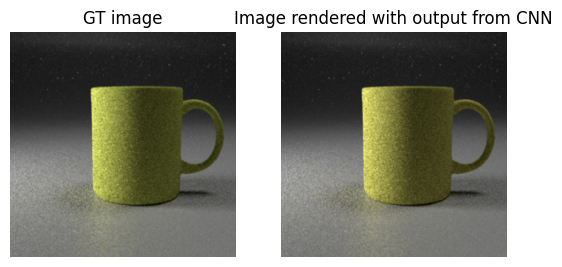

<Figure size 640x480 with 0 Axes>

In [109]:
print("Final loss:", loss.item())
test_color, test_image = gen_data()
output_color = model(test_image)
gt_image = image_for_plotting(test_image)
output_image = image_for_plotting(get_mts_rendering(output_color, apply_color, ctx_args))
print(f'GT color: {test_color}')
print(f'Output color: {output_color}')
plt.subplot(1, 2, 1)
plt.imshow(gt_image)
plt.title('GT image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Image rendered with output from CNN')
plt.axis('off')
plt.show()
plt.tight_layout()

# Add FR22 as decoder

## Setup

In [6]:
hparams['sigma'] = 0.01
ctx_args = {'scene': scene, 'params': params, 'spp': hparams['render_spp'],                     # rendering
            'init_vpos': initial_vertex_positions, 'mat_id': mat_id, 'update_fn': apply_color,    # rendering
            'sampler': 'importance', 'antithetic': True, 'nsamples': hparams['nsamples'],       # ours
            'sigma': hparams['sigma'], 'device': device}  

f_args = {'update_fn': apply_color, 'ctx_args': ctx_args}
kernel_args = {'sigma': hparams['sigma']}
sampler_args = {'sigma': hparams['sigma'], 'is_antithetic': ctx_args['antithetic'], 'dir':(0,0)}

## Training

Loss at step 0: 0.27491363883018494
Loss at step 10: 0.4242076873779297
Loss at step 20: 0.5067243576049805
Loss at step 30: 0.38377270102500916
Loss at step 40: 0.10990948975086212
Loss at step 50: 0.583911120891571
Loss at step 60: 0.3132241666316986
Loss at step 70: 0.4423391819000244
Loss at step 80: 0.3681924045085907
Loss at step 90: 0.1931154578924179
Loss at step 100: 0.6114555597305298
Loss at step 110: 0.27778881788253784
Loss at step 120: 0.458995521068573
Loss at step 130: 0.33139926195144653
Loss at step 140: 0.42589670419692993
Loss at step 150: 0.11519809812307358
Loss at step 160: 0.32170742750167847
Loss at step 170: 0.5032694339752197
Loss at step 180: 0.48166322708129883
Loss at step 190: 0.15092405676841736
Final loss: 0.22116342186927795
GT color: tensor([[0.8935, 0.3851, 0.5084]], device='cuda:0')
Output color: tensor([[-0.0232,  0.0044, -0.0525]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


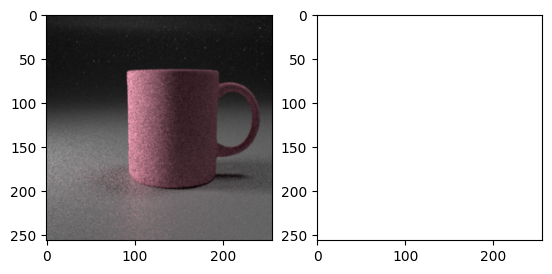

In [16]:
# optimization - with FR22 as decoder
n_params = 3  # Number of output parameters
model = CNN(n_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-11)
criterion = nn.MSELoss()
model.to(device)

diff_func = smoothFn_gradient_mi(func=render_smooth, n=ctx_args['nsamples'], f_args=f_args,
                        kernel_args=kernel_args, sampler_args=sampler_args, device=device)
max_step = 200
for i in range(max_step):
    gt_color, input_image = gen_data()
    output_color = model(input_image)

    # ours
    ctx_args['gt_image'] = input_image.permute(1, 2, 0) 
    grad = diff_func(output_color)
    optimizer.zero_grad()
    output_color.backward(gradient=grad)
    # print(grad)
    # print(output_color)
    loss = criterion(output_color, gt_color)
    # loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f'Loss at step {i}: {loss.item()}')
    if loss.item() < 1e-5:
        print(f'Converged at step {i}')
        break
        


Final loss: 0.22116342186927795
GT color: tensor([[0.8648, 0.4267, 0.1745]], device='cuda:0')
Output color: tensor([[-0.0234,  0.0045, -0.0525]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


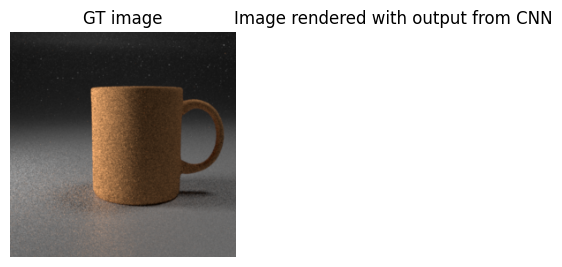

<Figure size 640x480 with 0 Axes>

In [21]:
print("Final loss:", loss.item())
test_color, test_image = gen_data()
output_color = model(test_image)
gt_image = image_for_plotting(test_image)
output_image = image_for_plotting(get_mts_rendering(output_color, apply_color, ctx_args))
print(f'GT color: {test_color}')
print(f'Output color: {output_color}')
plt.subplot(1, 2, 1)
plt.imshow(gt_image)
plt.title('GT image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Image rendered with output from CNN')
plt.axis('off')
plt.show()
plt.tight_layout()